In [3]:
%matplotlib inline
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from dateutil.parser import parse
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
data = pd.read_csv('google_drive_nanreplaced.csv')

In [4]:

data.head()

,time,1day_active_users,1day_google_documents_active_users,1day_google_drawings_active_users,1day_google_forms_active_users,1day_google_presentations_active_users,1day_google_sites_active_users,1day_google_spreadsheets_active_users,1day_other_types_active_users,30day_active_users,...,owned_items_with_visibility_unknown_delta,owned_items_with_visibility_unknown_removed,owned_other_types_added,owned_other_types_created,owned_other_types_delta,owned_other_types_edited,owned_other_types_removed,owned_other_types_trashed,owned_other_types_viewed,sharers
0,2017-03-12 05:00:00,1543.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,3509.0,0.0,193.0,0.0,173.0,1173.0,0.0
1,2017-03-14 04:00:00,2495.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,6275.0,0.0,837.0,0.0,1018.0,1759.0,0.0
2,2017-03-16 04:00:00,2403.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,22084.0,0.0,820.0,0.0,805.0,1451.0,0.0
3,2017-03-19 04:00:00,2848.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,51355.0,0.0,725.0,0.0,737.0,1247.0,0.0
4,2017-03-20 04:00:00,5302.0,2499.954068,7.240157,54.104987,474.077428,25.604369,1107.56168,1314.187664,15955.695538,...,0.0,0.0,0.0,9979.0,0.0,1330.0,0.0,924.0,2339.0,0.0


In [5]:
def pick_your_number(number):
    if (number == 1):
        df=data[['time','google_drawings_created','google_drawings_edited']]
        print("you picked google drawings edited and drawings created")
    if (number == 2):
        df=data
        print("you picked the entire data set")
    if (number ==3):
        df= data[['time','google_forms_created','google_forms_edited','1day_active_users','30day_active_users']]
        print("you picked 5 attributes")
    #else:
        #df=[]
        #print("you didn't pick any dataset")
    return df

In [6]:
def time_set(df):
    import datetime as dt
    df[df.columns[0]] = pd.to_datetime(df[df.columns[0]],utc = True)
    df[df.columns[0]]= df.time.dt.date
    df.set_index(df.columns[0], inplace=True)
    return df

In [7]:
def plot(df,df0):
    df1=df.copy()
    df2= df0.copy()
    df1= time_set(df1)
    df2= time_set(df2)
    for x in range(len(df1.columns)):
        plt.figure(figsize=(22,10))
        plt.plot(df1.index, df1[df1.columns[x]], label= df1.columns[x])
        plt.plot(df2.index,df2[df2.columns[x]], label= 'prophet', color='r')
        plt.legend(loc= 'best', fontsize='xx-large')
        plt.show()

In [8]:
def timeprediction123(df,csvfilename):
    p = Prophet(weekly_seasonality=True,  changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast
    
    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='180 days', horizon = '365 days')
    
    df_p = performance_metrics(df_cv)
    print("Performance head for " + csvfilename)
    print(df_p.head())
    print("Performance tail for " + csvfilename)
    print(df_p.tail())
    
    #df1.to_csv(data_path_write + csvfilename)
    df2 = time_pred[['yhat']]
    p.plot(time_pred)
    return df1,df2,time_pred

In [9]:
#mean absolute percent error
def timepredictionMAPE(df,csvfilename):
    p = Prophet(daily_seasonality=True, seasonality_mode='multiplicative', changepoint_prior_scale=0.7)
    #changepoint_prior changes the fit of the prediction
    df = df.rename(columns={df.columns[0]: "ds", df.columns[1]: "y"})
    
    df['ds'] = pd.to_datetime(df['ds'], utc=True)
    df['ds']= df.ds.dt.date
    df.index.freq = 'D'
    #get forecast
    
    p.fit(df)  # df is a pandas.DataFrame with 'y' and 'ds' columns
    future = p.make_future_dataframe(periods=365)
    time_pred = p.predict(future)
    df1 = time_pred[['ds','yhat']]
    df_cv = cross_validation(p, initial='370 days', period='180 days', horizon = '365 days')
    try:
        print("MAPE for " + csvfilename + " predictions")
        fig = plot_cross_validation_metric(df_cv, metric='mape')
    except:
        print("MAPE way too low to be graphed, prediction is very good")
    df2 = time_pred[['yhat']]
    return df1,df2,time_pred

In [10]:
def send_prediction(df):
    df_with_all_preds = timeprediction123(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : five_att.columns[1]})
    df1= df.drop(columns= [five_att.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timeprediction123(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

In [11]:
def send_predictionMAPE(df):
    df_with_all_preds = timepredictionMAPE(df = df[['time', df.columns[1]]], csvfilename = df.columns[1])[0]
    df_with_all_preds = df_with_all_preds.rename(columns= {df_with_all_preds.columns[0] : "time", df_with_all_preds.columns[1] : five_att.columns[1]})
    df1= df.drop(columns= [five_att.columns[1]])
    
    for x in range(len(df1.columns) - 1):
        h =timepredictionMAPE(df = df1[['time', df1.columns[x+1]]], csvfilename = df1.columns[x+1])[0]
        h =h.rename(columns = {h.columns[0]: "time", h.columns[1] : df1.columns[x+1]})
        df_with_all_preds =  df_with_all_preds.merge(h, on = "time")
    return df_with_all_preds

In [12]:
five_att = pick_your_number(1)

you picked google drawings edited and drawings created


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
C:\ProgramData\Anaconda3\lib\site-packages\pystan\misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):
INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Performance head for google_drawings_created
  horizon         mse       rmse        mae  coverage
0 36 days  284.783755  16.875537  16.339972       0.0
1 37 days  296.791424  17.227635  16.716838       0.0
2 38 days  300.423418  17.332727  16.843958       0.0
3 39 days  305.397471  17.475625  16.986017       0.0
4 40 days  313.735255  17.712573  17.316598       0.0
Performance tail for google_drawings_created
     horizon          mse       rmse        mae  coverage
321 361 days  2904.373997  53.892244  53.785003  0.833333
322 362 days  2924.737152  54.080839  53.960232  0.833333
323 363 days  2945.859855  54.275776  54.143728  0.833333
324 364 days  2985.659017  54.641184  54.482402  0.833333
325 365 days  3027.568941  55.023349  54.838197  0.805556


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0


Performance head for google_drawings_edited
  horizon         mse       rmse        mae  coverage
0 36 days  175.852853  13.260952  12.548827  0.055556
1 37 days  183.765239  13.556004  12.854938  0.055556
2 38 days  183.530338  13.547337  12.840542  0.055556
3 39 days  181.192226  13.460766  12.774569  0.055556
4 40 days  184.520121  13.583818  12.972331  0.027778
Performance tail for google_drawings_edited
     horizon          mse       rmse        mae  coverage
321 361 days  2010.787119  44.841801  44.700680  0.861111
322 362 days  2025.611649  45.006796  44.852450  0.888889
323 363 days  2041.315985  45.180925  45.015978  0.916667
324 364 days  2070.581201  45.503639  45.311019  0.916667
325 365 days  2102.952788  45.857963  45.635202  0.888889


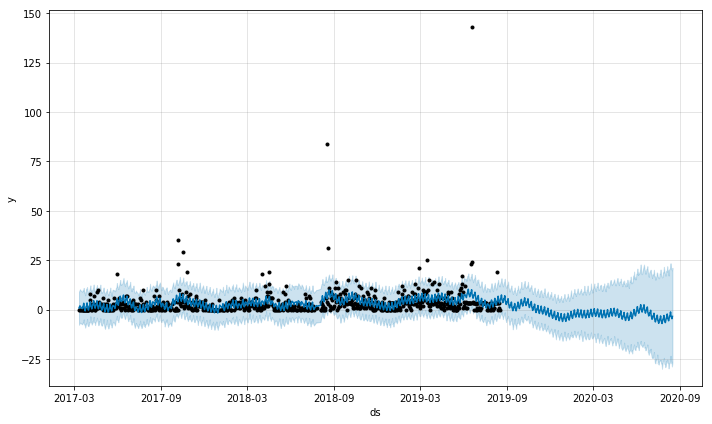

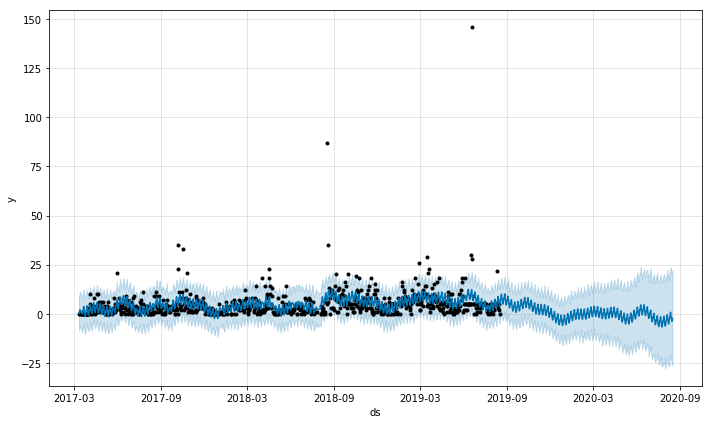

In [13]:
prediction = send_prediction(five_att)

INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Skipping MAPE because y close to 0


MAPE for google_drawings_created predictions
MAPE way too low to be graphed, prediction is very good


INFO:fbprophet:Making 1 forecasts with cutoffs between 2018-08-17 00:00:00 and 2018-08-17 00:00:00
INFO:fbprophet:Skipping MAPE because y close to 0
INFO:fbprophet:Skipping MAPE because y close to 0


MAPE for google_drawings_edited predictions
MAPE way too low to be graphed, prediction is very good


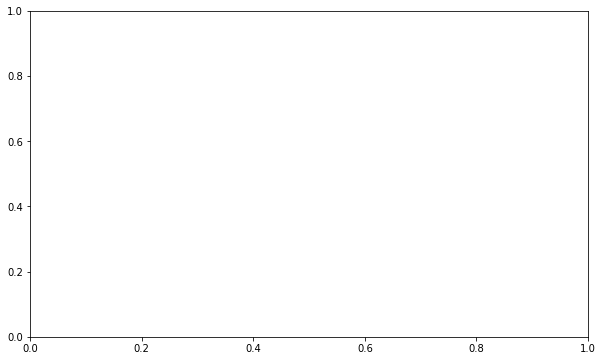

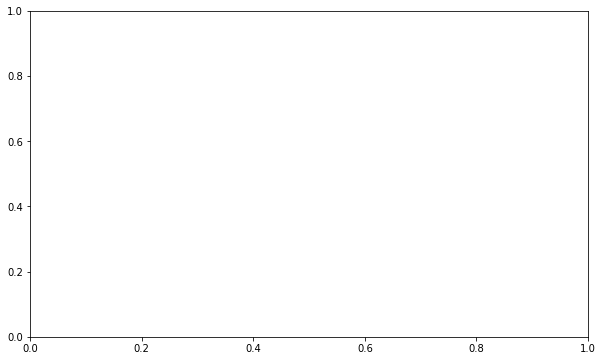

In [14]:

prediction1 = send_predictionMAPE(five_att)